<a href="https://colab.research.google.com/github/Jaesu26/Dacon-3D-MNIST-image-classification/blob/main/2022-08-16-%EC%88%AB%EC%9E%903D%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 숫자 3D 이미지 분류 AI 경진대회

## 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import h5py
import cv2
import os
import gc

from tqdm import tqdm, tqdm_notebook
from glob import glob

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [ ]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data


In [ ]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data/open.zip'

In [ ]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류


- 데이터 불러오기

In [ ]:
label_df = pd.read_csv('./Data/train.csv')
# all_points = h5py.File('./Data/train.h5', 'r')

In [ ]:
test_df = pd.read_csv('./Data/sample_submission.csv')
# test_points = h5py.File('./Data/test.h5', 'r')

- 하이퍼파라미터

In [ ]:
SAVE_PATH = './weight'
MODEL_NAME = 'convmixer'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_NAME}_default_weight.pt' 
NUM_CLASSES = 10
N_FOLD = 5
BATCH_SIZE = 32
EPOCHS = 50 
LEARNING_RATE = 1e-6
LABEL_SMOOTHING = 0.05
SEED = 2022

- 가중치 저장폴더

In [ ]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [ ]:
create_folder(SAVE_PATH)

## 시각화

- 라벨

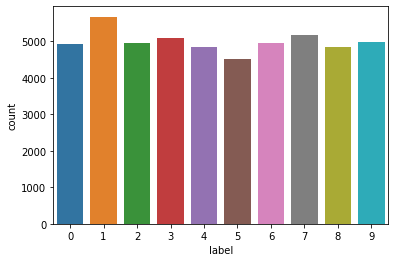

In [ ]:
sns.countplot(data=label_df, x='label')

`-` 라벨별 개수는 비슷하다

In [ ]:
def show_3Dimage(_3d_point_images, id: int, label_df=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    _3d_point_image = _3d_point_images[str(id)][:]
    x = _3d_point_image[:, 0]
    y = _3d_point_image[:, 1]
    z = _3d_point_image[:, 2]
    ax.scatter(x, y, z, alpha=0.04)

    if label_df is not None:
        label = label_df.loc[label_df['ID'] == id, 'label'].item()
        ax.set_title(label, fontsize=16)
    plt.show()

- 3차원 이미지

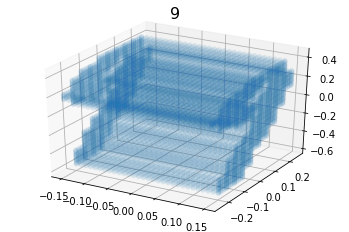

In [ ]:
show_3Dimage(all_points, 24983, label_df)

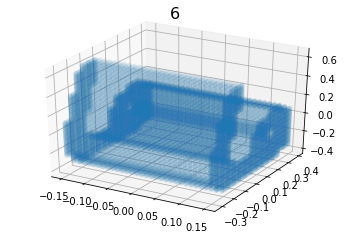

In [ ]:
show_3Dimage(all_points, 49977, label_df)

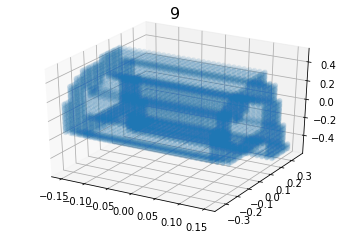

In [ ]:
show_3Dimage(all_points, 49983, label_df)

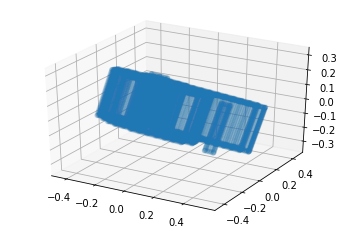

In [ ]:
show_3Dimage(test_points, 81110)

`-` train 이미지는 yz 평면에 숫자를 그린 후 x축으로 팽창되어 있다

`-` test 이미지는 그렇지 않기에(대략 1:1 비율) 적절한 변환이 필요하다  

`-` 6과 9는 뒤집어져 있으면 구분이 안되지만 위와 같이 옆으로 누워있는 3D 이미지도 존재한다

`-` 6의 경우 막대기가 강조되어 있으며 9의 경우 동그라미가 강조되어 있다 

`-` 2와 5도 뒤집어져 있으면 구분이 잘 안된다

`-` 나머지는 구분이 잘 된다

- 3차원 이미지 좌표의 분포 확인

- train

In [ ]:
count = 0
for i in tqdm(range(50000, 90000)):
    data = test_points[str(i)][:]
    xx = np.max(data[:, 0])
    if xx >= 0.16:
        count += 1

100%|██████████| 40000/40000 [04:07<00:00, 161.62it/s]


In [ ]:
count

19987

In [ ]:
x_data, y_data, z_data = [], [], []
for i in tqdm(range(50000)):
    data = all_points[str(i)][:]
    x_data.extend(list(set(data[:, 0])))
    y_data.extend(list(set(data[:, 1])))
    z_data.extend(list(set(data[:, 2])))

100%|██████████| 50000/50000 [09:55<00:00, 84.03it/s]


In [ ]:
len(x_data), len(y_data), len(z_data)

(19421718, 3182493, 8463666)

{'boxes': [<matplotlib.lines.Line2D at 0x7f52f4822710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f52f482d750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f52f4836750>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f52f4836250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f52f4822c90>,
  <matplotlib.lines.Line2D at 0x7f52f482d210>]}

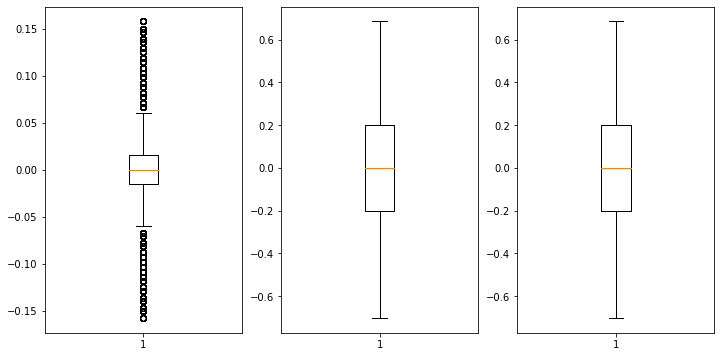

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(x_data)
ax2.boxplot(y_data)
ax3.boxplot(y_data)

- test

In [ ]:
x_data, y_data, z_data = [], [], []
dot_counts = []
for i in tqdm(range(50000, 55000)):
    data = test_points[str(i)][:]
    dot_counts.append(data.shape[0])
    x_data.extend(list(set(data[:, 0])))
    y_data.extend(list(set(data[:, 1])))
    z_data.extend(list(set(data[:, 2])))

100%|██████████| 5000/5000 [01:30<00:00, 55.02it/s]


In [ ]:
len(x_data), len(y_data), len(z_data), max(dot_counts)

(42576466, 41770274, 42032192, 34750)

{'boxes': [<matplotlib.lines.Line2D at 0x7efc8f53ef50>],
 'caps': [<matplotlib.lines.Line2D at 0x7efc8f548d50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efc8f54fe50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efc8f54f910>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efc8f548390>,
  <matplotlib.lines.Line2D at 0x7efc8f5488d0>]}

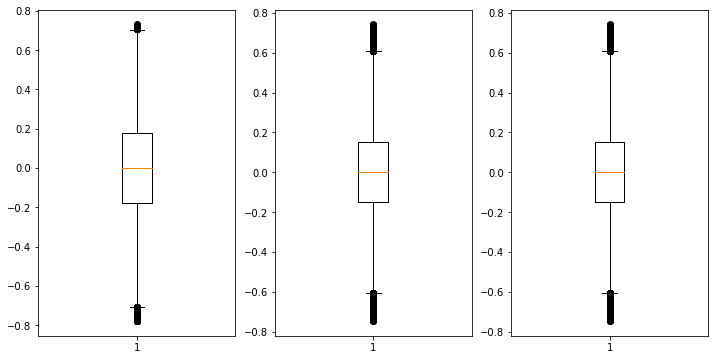

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(x_data)
ax2.boxplot(y_data)
ax3.boxplot(y_data)

`-` train과 비교했을 때 x축의 범위가 5배는 더 넓다

`-` train 데이터의 경우 x축의 범위가 -0.15~0.15 이다

`-` train 이미지는 yz 평면에 숫자를 그리고 x축으로 팽창시킨 반면에 test는 그렇지 않다

`-` RAM 용량 문제로 test data는 5000개만 사용함

## 데이터 전처리

`-` 위의 시각화를 보면 3차원이 아니라 2차원이더라도 숫자를 구분할 수 있을 듯하다

`-` 3차원 points를 2차원 이미지로 변경하자

`-` pretrained model도 사용할 수 있으며 파라미터도 더 적어진다

### 3D points $\to$ 2D points 

`-` 3D points는 축 하나의 범위가 -0.15 ~ 0.15인 경우와 그렇지 않은 경우로 나뉜다

`-` 전자의 경우 -0.15 ~ 0.15의 범위를 가지는 축으로 3차원 점들을 정사영시키면 된다 

`-` 후자의 경우 특이값 분해 또는 고유값 분해를 이용하여 2차원 점으로 만든다 (고유값 분해가 더 낫다)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def z_scale(points):
    col = points.shape[1]
    scaled_points = []

    for i in range(col):
        p = points[:, i]
        pp = (p - np.mean(p)) / np.std(p)
        scaled_points.append(pp)

    scaled_points = np.column_stack(tuple(scaled_points))
    return scaled_points

In [ ]:
def svd_3d_to_2d(_3d_points_array, scaling=False):
    """ SVD를 이용하여 3D 이미지를 2D 이미지로 축소"""
    X = _3d_points_array
    if scaling:
        X = z_scale(X)

    U, d, V = np.linalg.svd(X.T @ X)
    V_tilde = np.column_stack((-V[:, 1], -V[:, 0])) ## 각도 조절
    _2d_point_array = X @ V_tilde
    return _2d_point_array

In [ ]:
def eig_3d_to_2d(_3d_points_array, scaling=False):
    """ 고유값 분해를 이용하여 3D 이미지를 2D 이미지로 축소 """
    X = _3d_points_array
    if scaling:
        X = z_scale(X)

    Lambda, Psi = np.linalg.eig(X.T @ X)
    _1st, _2nd, _3rd = sorted(Lambda, key = lambda x: -x)  ## 내림차순 정렬
    idx_1st = np.array(list(np.where(Lambda == _1st))).item(0, 0)
    idx_2nd = np.array(list(np.where(Lambda == _2nd))).item(0, 0)
    
    Psi_tilde = np.column_stack((-Psi[:, idx_2nd], -Psi[:, idx_1st])) ## 각도 조절
    _2d_point_array = X @ Psi_tilde
    return _2d_point_array

In [ ]:
def show_2Dimages(_3d_points_images, id, scaling=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
    pca = PCA(n_components=2)

    X = _3d_points_images[str(id)][:]
    svd_z = svd_3d_to_2d(X, scaling)
    eig_z = eig_3d_to_2d(X, scaling)
    pca_z = pca.fit_transform(X)

    ax1.plot(svd_z[:,0], svd_z[:,1], '.', alpha=0.5)
    ax2.plot(eig_z[:,0], eig_z[:,1], '.', alpha=0.5)
    ax3.plot(pca_z[:,0], pca_z[:,1], '.', alpha=0.5)

    ax1.set_title('SVD')
    ax2.set_title('Eigen')
    ax3.set_title('PCA')
    plt.show()    

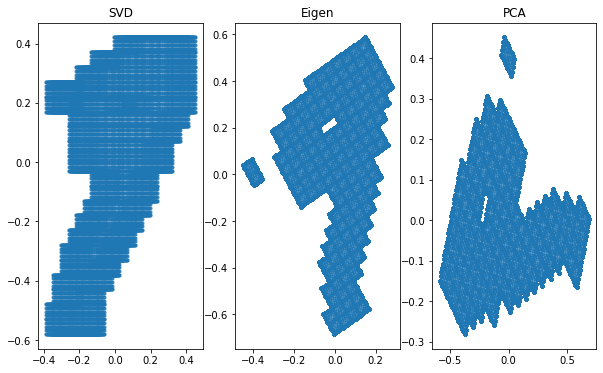

In [ ]:
show_2Dimages(all_points, 41483)

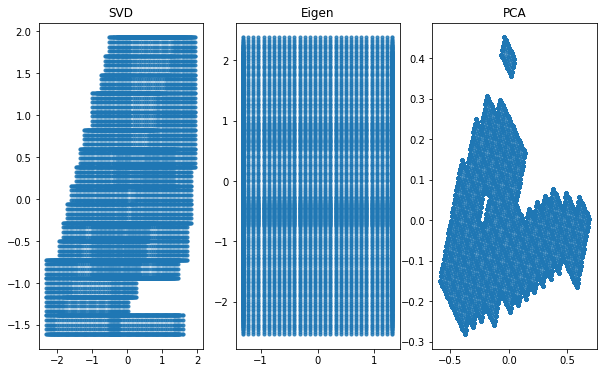

In [ ]:
show_2Dimages(all_points, 41483, scaling=True)

`-` SVD와 고유값 분해는 output의 차이가 존재한다 (무엇이 어떻게 다른지 까먹어서 공부해야...)

`-` 고유값 분해가 SVD 보다 원본 이미지를 잘 보존하는 듯하다

`-` PCA는 고유값 분해와 output이 동일하다 (각도만 다르다)

`-` 식별 가능한 이미지를 생성하기엔 스케일링을 하지 않는 것이 더 낫다

`-` 스케일링을 하면 팽창된 부분 (-0.15 ~ 0.15)의 range가 다른 axis의 range와 비슷해져 원본 이미지를 보존하지 못한다 (스케일링 한 것과 안 한것을 비교하면 바로 알 수 있음)

`-` [$\star$] 위 코드의 목적은 데이터 분산을 보존하는 것이 아니라 `식별 가능한 이미지`를 `보존`하는 것이다 [$\star$]

- just 정사영

In [ ]:
def project_point2plane(_3d_points_array):
    """
    xy or yz or zx 평면에 숫자를 그리고(draw) 나머지 하나의 축으로 팽창시킨 경우 (축의 범위: -0.15 ~ 0.15)  
    """
    x = _3d_points_array[:, 0]
    y = _3d_points_array[:, 1]
    z = _3d_points_array[:, 2]

    x_range = np.max(x) - np.min(x)
    y_range = np.max(y) - np.min(y)
    z_range = np.max(z) - np.min(z)

    if 0.28 < x_range < 0.32:  ## 범위가 대략 -0.15 ~ 0.15 이니까 range는 대략 0.28 ~ 0.32 일 것이다
        new_x = _3d_points_array[:, 1]
        new_y = _3d_points_array[:, 2]
    elif 0.28 < y_range < 0.32:
        new_x = _3d_points_array[:, 0]
        new_y = _3d_points_array[:, 2]
    elif 0.28 < z_range < 0.32:
        new_x = _3d_points_array[:, 0]
        new_y = _3d_points_array[:, 1]
    else:
        return None

    _2d_point_array = np.column_stack((new_x, new_y))
    return _2d_point_array

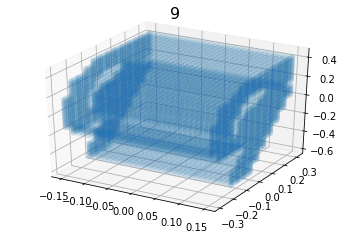

In [ ]:
show_3Dimage(all_points, 3483, label_df)

In [ ]:
z = project_point2plane(all_points['3483'][:])

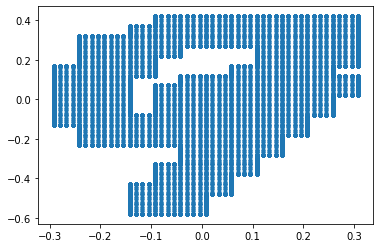

In [ ]:
plt.plot(z[:, 0], z[:, 1], '.')

### 2D points $\to$ 2D image

`-` size $\times$ size 크기의 격자를 만들고 격자 내부의 해당하는 점의 개수를 픽셀값으로 하여 2D 이미지를 만들겠다

In [ ]:
def points2image(points, x_y=[28, 28]):
    ## (xmax, ymax), (xmax, ymin), (xmin, ymax), (xmin, ymin)을 네 점으로 하는 사각형 생성
    delta = 0.1
    xmax = np.max(points[:, 0]) + delta
    xmin = np.min(points[:, 0]) - delta
    ymax = np.max(points[:, 1]) + delta
    ymin = np.min(points[:, 1]) - delta

    x_linspace = np.linspace(xmin, xmax, x_y[0] + 1)
    y_linspace = np.linspace(ymin, ymax, x_y[1] + 1)
    image_array = np.zeros(x_y)  ## 이미지 배열 선언

    x_idx = np.searchsorted(x_linspace, points[:, 0]) -1  ## 0 ~ x_y[0] - 1 
    y_idx = np.searchsorted(y_linspace, points[:, 1]) -1  ## 0 ~ x_y[1] - 1

    for x, y in zip(x_idx, y_idx):
        image_array[x_y[1] - y - 1][x] += 1
    return image_array

`-` size가 너무 크면 윤곽선만 남는다 (대부분의 점들이 윤곽선 근처에 모여있음)

`-` size를 작게 하고 torchvision 같은 패키지를 활용해 크게 만드는 것이 낫다

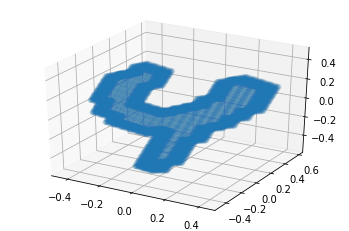

In [ ]:
show_3Dimage(test_points, 50001)

In [ ]:
z = eig_3d_to_2d(test_points['50001'][:])

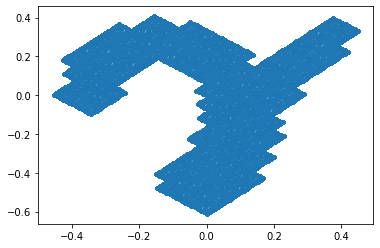

In [ ]:
plt.plot(z[:, 0], z[:, 1], '.')

In [ ]:
img = points2image(z, x_y=[28, 28])

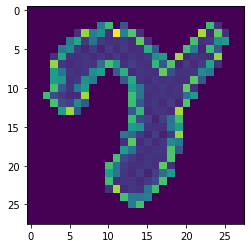

In [ ]:
plt.imshow(img / 255)

- 예외 case

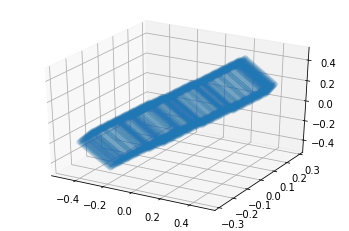

In [ ]:
show_3Dimage(test_points, 50759)

In [ ]:
z = eig_3d_to_2d(test_points['50759'][:])

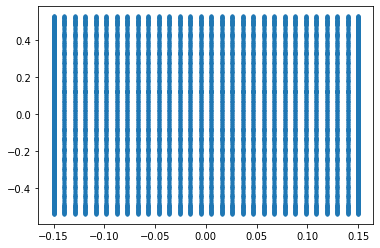

In [ ]:
plt.plot(z[:, 0], z[:, 1], '.')

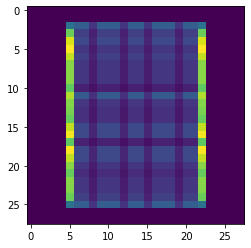

In [ ]:
img = points2image(z, x_y=[28, 28])
plt.imshow(img / 255)

In [ ]:
img[:, 22] - img[:, 5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

`-` 이런 경우 특이값 분해를 이용

In [ ]:
z = svd_3d_to_2d(test_points['50759'][:])

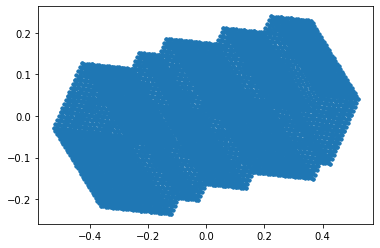

In [ ]:
plt.plot(z[:, 0], z[:, 1], '.')

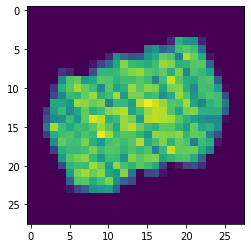

In [ ]:
img = points2image(z, x_y=[28, 28])
plt.imshow(img / 255)

- 3D points $\to$ 2D points $\to$ 2D image

In [ ]:
def get_2d_images(_3d_points_array, id_df, x_y=[28, 28]):   
    all_images = []
    for i in tqdm(id_df.values):
        just_projection = True
        _3d_points = _3d_points_array[str(i)][:]
        _2d_points = project_point2plane(_3d_points)

        if _2d_points is None:
            _2d_points = eig_3d_to_2d(_3d_points)
            just_projection = False

        _2d_image = points2image(_2d_points, x_y)
        if not just_projection and np.sum((_2d_image[:, 22] - _2d_image[:, 5]) ** 2) <= 28:  ## 고유값 분해로 원본 이미지를 표현하지 못하면 SVD 사용 (test: 대략 4%)
            _2d_points = svd_3d_to_2d(_3d_points)
            _2d_image = points2image(_2d_points, x_y)  

        all_images.append(_2d_image)
    return all_images

`-` 위의 방식대로 수행해도 test 원본 이미지를 식별하지 못하는 경우가 있다

`-` 이런 경우 이미지는 위에서 scaling을 했을 때의 차원 축소를 적용한 이미지와 비슷하게 생겼다 (모델은 아마 1로 예측할 듯)

`-` 이런 경우 특이값 분해를 사용하거나 특이값 분해도 마찬가지라면 단순히 평면 (xy, yz, zx)에 정사영 시키는 것을 고려해야 한다 (근데 어느 평면에?...)

In [ ]:
train_images = get_2d_images(all_points, label_df['ID'])

100%|██████████| 50000/50000 [26:47<00:00, 31.10it/s]


In [ ]:
np.array(train_images).shape

(50000, 28, 28)

In [ ]:
test_images = get_2d_images(test_points, test_df['ID'])

100%|██████████| 40000/40000 [24:25<00:00, 27.30it/s]


In [ ]:
np.array(test_images).shape

(40000, 28, 28)

- 이미지를 벡터로 변환 후 csv파일로 저장

In [ ]:
train_vectors = np.array(train_images).reshape(-1, 28*28)
test_vectors = np.array(test_images).reshape(-1, 28*28)

In [ ]:
train_vectors.shape, test_vectors.shape

((50000, 784), (40000, 784))

In [ ]:
train_data = pd.DataFrame([])
train_data['ID'] = list(range(50000))

test_data = pd.DataFrame([])
test_data['ID'] = list(range(50000, 90000))

In [ ]:
for i in range(28*28):
    train_data[f'X{i}'] = train_vectors[:, i]
    test_data[f'X{i}'] = test_vectors[:, i]

In [ ]:
# train_data.to_csv('./Data/train_array.csv', index=False)
# test_data.to_csv('./Data/test_array.csv', index=False)

## 모델 학습 준비

In [ ]:
# !pip install albumentations==1.2.1
!pip install adabelief-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
from adabelief_pytorch import AdaBelief

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [ ]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [ ]:
def seed_everything(seed=22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

- 학습 이미지

In [ ]:
def change_max_pixel_value(image, new_max_pixel_value=1.0):
    max_pixel_value = np.max(image)
    if max_pixel_value > new_max_pixel_value:
        image = image * (new_max_pixel_value / max_pixel_value)
    return image

In [ ]:
train_data = pd.read_csv('./Data/train_array.csv').drop('ID', axis=1)
test_data = pd.read_csv('./Data/test_array.csv').drop('ID', axis=1)

- 이미지 픽셀의 최댓값을 1로 변경

In [ ]:
for i in tqdm(range(50000)):
    train_data.loc[i, :] = change_max_pixel_value(train_data.loc[i, :])

100%|██████████| 50000/50000 [00:26<00:00, 1894.61it/s]


In [ ]:
for i in tqdm(range(40000)):
    test_data.loc[i, :] = change_max_pixel_value(test_data.loc[i, :])

100%|██████████| 40000/40000 [00:19<00:00, 2069.21it/s]


- 이미지의 채널을 3차원으로 변경

In [ ]:
train_images = train_data.to_numpy().reshape(-1, 28, 28, 1)
test_images = test_data.to_numpy().reshape(-1, 28, 28, 1)

In [ ]:
train_images = np.concatenate([train_images, train_images, train_images], axis=-1).astype(np.float32)
test_images = np.concatenate([test_images, test_images, test_images], axis=-1).astype(np.float32)

In [ ]:
train_images.shape, test_images.shape

((50000, 28, 28, 3), (40000, 28, 28, 3))

- 2D 이미지 시각화

In [ ]:
def show_images(images, labels, nrows=4, ncols=4) -> None:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*2, ncols*2))
    nums = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))
    
    for i, ax in enumerate(axs.flatten()):
        num = nums[i]
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[num])
        ax.imshow(images[num])
    fig.tight_layout()

- 숫자 6과 9

In [ ]:
idx_6 = label_df.query('label == 6').index
idx_9 = label_df.query('label == 9').index

- 숫자 6 이미지

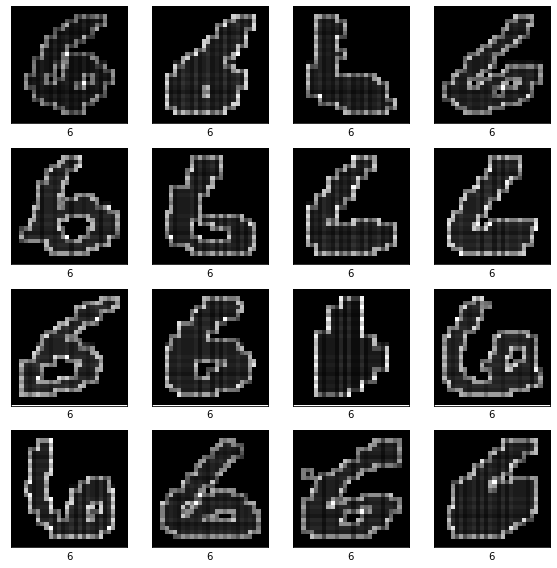

In [ ]:
show_images(train_images[idx_6], label_df.loc[idx_6, 'label'].values)

- 숫자 9 이미지

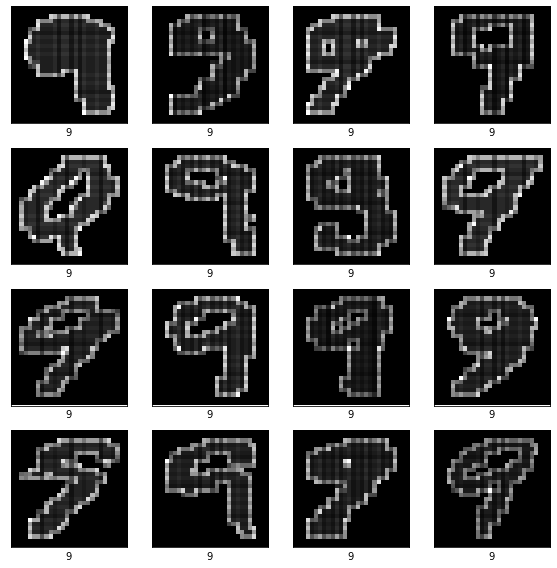

In [ ]:
show_images(train_images[idx_9], label_df.loc[idx_9, 'label'].values)

- 숫자 2와 5

In [ ]:
idx_2 = label_df.query('label == 2').index
idx_5 = label_df.query('label == 5').index

- 숫자 2 이미지

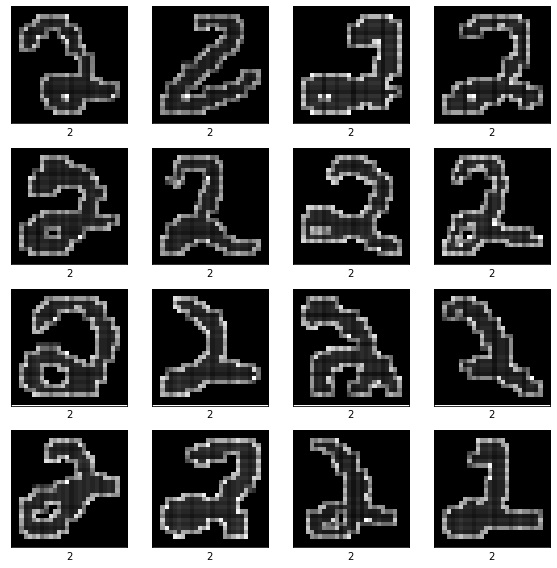

In [ ]:
show_images(train_images[idx_2], label_df.loc[idx_2, 'label'].values)

- 숫자 5 이미지

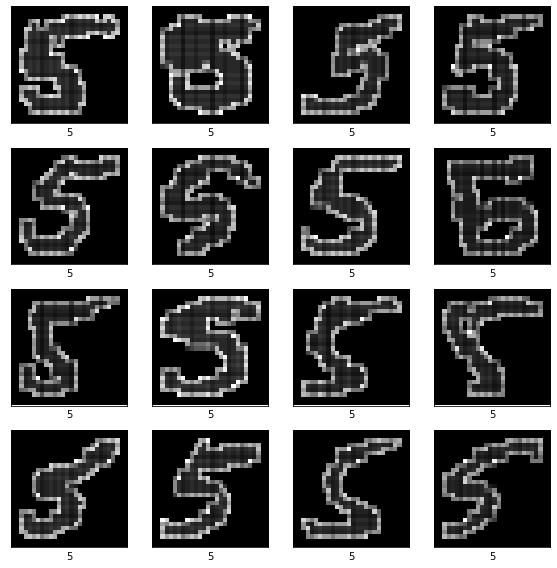

In [ ]:
show_images(train_images[idx_5], label_df.loc[idx_5, 'label'].values)

- Test 이미지

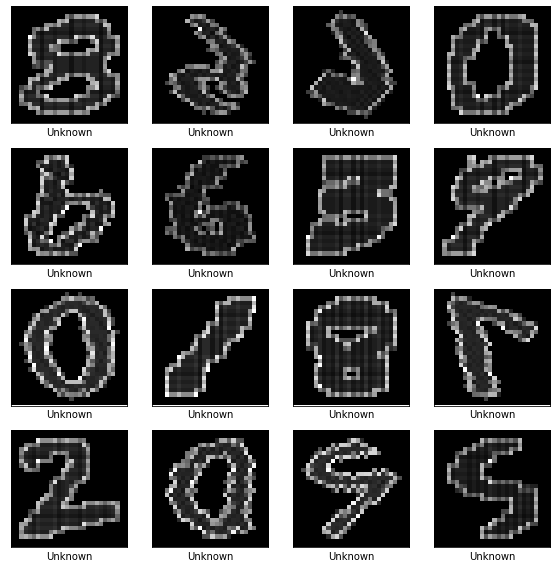

In [ ]:
show_images(test_images, ['Unknown'] * 50000)

- 데이터 셋

In [ ]:
class CustomDataset(Dataset):
  
    def __init__(self, images, labels=None, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images)

In [ ]:
def get_dataloader(X, y=None, transforms=None, shuffle_dataloader=True):
    dataset = CustomDataset(X, y, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

- 데이터 변환

`-` https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py

`-` 위의 링크를 통해 변환함수들의 구조를 확인하자

In [ ]:
RGB_MEAN = [np.mean((train_images[..., i])) for i in range(3)] 
RGB_STD = [np.std(train_images[..., i]) for i in range(3)]  

In [ ]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(train_mode=True):
    transforms = A.Compose([
        A.Resize(42, 42),
        A.Normalize(mean=RGB_MEAN, std=RGB_STD, max_pixel_value=1.0), 
        ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환 
    ])
    
    if train_mode:
        transforms = A.Compose([
            A.Resize(42, 42),
            A.RandomGamma(gamma_limit=(80, 120), p=0.3),  ## X -> (X ** gamma_list[0] ~ X ** gamma_list[1])
            A.GaussNoise(var_limit=(0.005, 0.015), p=0.3),  ## X -> X + gauss -> 최댓값을 1로 변환 
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.Perspective(scale=0.1, p=0.5),
            A.Cutout(num_holes=4, max_h_size=3, max_w_size=3, p=0.5),
            A.HorizontalFlip(p=0.5), 
            A.VerticalFlip(p=0.5),  
            A.Rotate(limit=40, border_mode=cv2.BORDER_CONSTANT, p=0.5),  ## 무작위로 -limit~limit 각도 회전
            A.Normalize(mean=RGB_MEAN, std=RGB_STD, max_pixel_value=1.0), 
            ToTensorV2() ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환  
        ])

    return transforms ## 데이터 변환 방식을 반환

In [ ]:
target = label_df['label'].values

- 딥러닝 모델

In [ ]:
## 코드: https://github.com/locuslab/convmixer/blob/main/convmixer.py
class Residual(nn.Module):
  
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=3, patch_size=3, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding='same'),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

- 가중치 초기화

In [ ]:
## layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        nn.init.normal_(m.weight.data, 0.0, np.sqrt(2 / y))
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

- 조기 중단

In [ ]:
## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', model_name='', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7

            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
                            
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0
        self.delta = delta
        self.path = path
        self.model_name = model_name
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):
        score = -val_loss  ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:  ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(val_loss, val_acc, model) 
            self.counter = 0  ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.n_fold}.pt') 
        self.val_loss_min = val_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc  ## 이때의 valid accuracy도 변경해준다

- 스케쥴러

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler

## 코드: https://github.com/amirmk89/gepc/blob/master/utils/optim_utils/schedulers/cosine_annealing_with_warmup.py
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError('Expected positive integer T_0, but got {}'.format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError('Expected integer T_mult >= 1, but got {}'.format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError('Expected positive integer T_up, but got {}'.format(T_up))

        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr) * self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur - self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma ** self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## 모델 교차검증

In [ ]:
from sklearn.model_selection import StratifiedKFold

- Kfold와 손실 함수

In [ ]:
skfold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [ ]:
def train(model, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 에폭 하나당 배치들의 평균 훈련 오차를 반환"""  
    train_avg_loss = 0  ## 에폭별 배치단위 평균 훈련 오차 
    model = model.to(device)
    model.train()

    for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        yhat = model(X)
        loss = loss_fn(yhat, y)  
        optimizer.zero_grad()  ## 그래디언트 초기화
        loss.backward()   ## 미분
        optimizer.step()  ## 업데이트
        train_avg_loss += (loss.item() / len(dataloader)) 
  
    ## 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [ ]:
def evaluate(model, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 에폭 하나당 배치들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y)  
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset))  ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader)    

    return valid_avg_loss, valid_avg_acc

In [ ]:
def show_loss_plot(train_loss, valid_loss, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [ ]:
def kfold_training(model, X, y, skfold, loss_fn):
    seed_everything(SEED)  ## 정확한 loss 재현을 위함
    model_avg_acc = []  ## fold 마다 valid셋의 평균 정확도
    model_avg_loss = []  ## fold 마다 valid셋의 평균 손실
    model_epoch_train_loss = [[] for _ in range(N_FOLD)]  ## fold 마다 train의 한 epoch당 valid의 배치 평균 손실
    model_epoch_valid_loss = [[] for _ in range(N_FOLD)]  ## fold 마다 valid의 한 epoch당 valid의 배치 평균 손실

    for i, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{i + 1} / {N_FOLD}] Fold Training......')

        ## 메모리 절약
        gc.collect()
        torch.cuda.empty_cache()
        
        ## 학습 데이터와 평가 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]
        y_train = torch.tensor(y_train, dtype=torch.int64)   
        y_valid = torch.tensor(y_valid, dtype=torch.int64)   

        ## Dataloader
        train_dataloader = get_dataloader(X_train, y_train, get_transforms(train_mode=True))
        valid_dataloader = get_dataloader(X_valid, y_valid, get_transforms(train_mode=False))

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device)) 

        ## optimizer, scheduler
        # optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) 
        optimizer = AdaBelief(model.parameters(),
                      lr=1e-3,  ## LEARNING_RATE
                      eps=1e-8,
                      weight_decay=1e-3,
                      betas=(0.9, 0.999),
                      weight_decouple=True,
                      rectify=False,
                      print_change_log=False)
        
        scheduler = None
        # scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=15, T_mult=1, eta_max=1e-3, T_up=5, gamma=0.25)

        ## early stopping
        early_stopping = EarlyStopping(patience=5,
                                       verbose=False,
                                       path=SAVE_PATH,
                                       model_name=MODEL_NAME,
                                       n_fold=i+1)  ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
        
        ## fold 마다 모델 학습
        for epoch in tqdm_notebook(range(EPOCHS)): ## (배치사이즈 * 에폭) 만큼 훈련시킴           
            model, train_avg_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
            valid_avg_loss, valid_avg_acc = evaluate(model, valid_dataloader, loss_fn)  ## 모델 평가
            model_epoch_train_loss[i].append(train_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
            model_epoch_valid_loss[i].append(valid_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

            if epoch % 5 == 0 or epoch == EPOCHS - 1: 
                ## 5의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}  valid acc = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss, valid_avg_acc)) 
                
            ## epoch 마다 early stopping 실행
            early_stopping(model, valid_avg_loss, valid_avg_acc)  ## __call__ function
            if early_stopping.early_stop:  ## early_stop이 true이면
                if epoch % 5 != 0 and epoch != EPOCHS - 1:
                    print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}  valid acc = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss, valid_avg_acc)) 
                print('Early stopping!')
                break 

        model_avg_acc.append(early_stopping.val_acc)  ## fold 마다 loss가 가장 작은 모델의 정확도
        model_avg_loss.append(early_stopping.val_loss_min)  ## fold 마다 loss가 가장 작은 모델의 손실
        
        ## fold 마다 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
        print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
        
    ## 마지막으로 fold 마다 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
    print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(model_avg_acc):.4f}')
    print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(model_avg_loss):.4f}')

    return model, model_epoch_train_loss, model_epoch_valid_loss, model_avg_acc, model_avg_loss

- 모델 선언 및 초기화시킨 가중치 저장

In [ ]:
seed_everything(SEED)
model = ConvMixer(dim=2**8, depth=11, kernel_size=3, patch_size=3, n_classes=NUM_CLASSES)
model.apply(init_weights)
torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH)

- 모델 K겹 교차검증

In [61]:
model, model_epoch_train_loss, model_epoch_valid_loss, _, _ = kfold_training(model, train_images, target, skfold, loss_fn)

[1 / 5] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch:   1] train loss = 0.98845  valid loss = 0.55429  valid acc = 0.9226
[Epoch:   6] train loss = 0.46479  valid loss = 0.3846  valid acc = 0.9741
[Epoch:  11] train loss = 0.41677  valid loss = 0.3626  valid acc = 0.9787
[Epoch:  16] train loss = 0.39447  valid loss = 0.35634  valid acc = 0.978
[Epoch:  21] train loss = 0.38066  valid loss = 0.34109  valid acc = 0.9837
[Epoch:  25] train loss = 0.37331  valid loss = 0.34243  valid acc = 0.9833
Early stopping!
1 Fold -> Best Valid Loss: 0.3400  Best Valid Accuracy: 0.9841


[2 / 5] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.0274  valid loss = 0.52829  valid acc = 0.9288
[Epoch:   6] train loss = 0.47194  valid loss = 0.38828  valid acc = 0.9722
[Epoch:  11] train loss = 0.42067  valid loss = 0.36555  valid acc = 0.9779
[Epoch:  16] train loss = 0.3986  valid loss = 0.35412  valid acc = 0.9809
[Epoch:  21] train loss = 0.38443  valid loss = 0.34564  valid acc = 0.9825
[Epoch:  26] train loss = 0.37344  valid loss = 0.33924  valid acc = 0.9844
[Epoch:  31] train loss = 0.36586  valid loss = 0.33728  valid acc = 0.9832
[Epoch:  32] train loss = 0.3623  valid loss = 0.33715  valid acc = 0.983
Early stopping!
2 Fold -> Best Valid Loss: 0.3353  Best Valid Accuracy: 0.9856


[3 / 5] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.0017  valid loss = 0.57558  valid acc = 0.9159
[Epoch:   6] train loss = 0.47142  valid loss = 0.38359  valid acc = 0.9745
[Epoch:  11] train loss = 0.42154  valid loss = 0.36363  valid acc = 0.9786
[Epoch:  16] train loss = 0.39871  valid loss = 0.34403  valid acc = 0.9834
[Epoch:  21] train loss = 0.38061  valid loss = 0.34624  valid acc = 0.9833
Early stopping!
3 Fold -> Best Valid Loss: 0.3440  Best Valid Accuracy: 0.9834


[4 / 5] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch:   1] train loss = 0.99004  valid loss = 0.56804  valid acc = 0.9126
[Epoch:   6] train loss = 0.46547  valid loss = 0.39377  valid acc = 0.967
[Epoch:  11] train loss = 0.41699  valid loss = 0.36344  valid acc = 0.9774
[Epoch:  16] train loss = 0.39589  valid loss = 0.3559  valid acc = 0.9787
[Epoch:  21] train loss = 0.37908  valid loss = 0.34992  valid acc = 0.9812
[Epoch:  22] train loss = 0.37654  valid loss = 0.35032  valid acc = 0.98
Early stopping!
4 Fold -> Best Valid Loss: 0.3490  Best Valid Accuracy: 0.9815


[5 / 5] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch:   1] train loss = 0.98365  valid loss = 0.54843  valid acc = 0.9277
[Epoch:   6] train loss = 0.46765  valid loss = 0.38567  valid acc = 0.9735
[Epoch:  11] train loss = 0.41922  valid loss = 0.36257  valid acc = 0.9803
[Epoch:  16] train loss = 0.39513  valid loss = 0.37045  valid acc = 0.9759
[Epoch:  21] train loss = 0.38202  valid loss = 0.35285  valid acc = 0.9789
[Epoch:  26] train loss = 0.37436  valid loss = 0.34757  valid acc = 0.9818
[Epoch:  31] train loss = 0.36714  valid loss = 0.34277  valid acc = 0.9831
[Epoch:  36] train loss = 0.35758  valid loss = 0.33922  valid acc = 0.9842
[Epoch:  41] train loss = 0.35493  valid loss = 0.33612  valid acc = 0.9848
[Epoch:  44] train loss = 0.35015  valid loss = 0.33711  valid acc = 0.9833
Early stopping!
5 Fold -> Best Valid Loss: 0.3358  Best Valid Accuracy: 0.9847


5 Fold Mean Valid Accuracy: 0.9839
5 Fold Mean Valid Loss: 0.3408


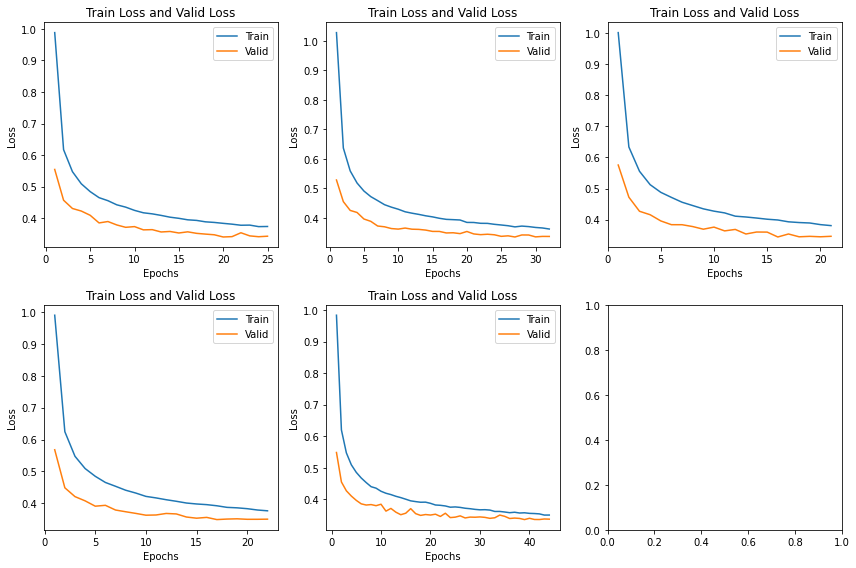

In [62]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(2, 3, figsize=(12, 8)) 
for i, ax in enumerate(axs.flatten()):
    try:
        show_loss_plot(model_epoch_train_loss[i], model_epoch_valid_loss[i], ax)
    except:
        pass
fig.tight_layout()

## Test 예측

In [63]:
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import ttach as tta

`-` 3차원 이미지를 2차원 이미지로 축소된 결과물이 일반적으로 알고있는 형태와 다르다 (예컨대 6이 거꾸로 뒤집어 있다)

`-` 왜냐하면 같은 라벨이더라도 3차원 상에서 rotate, flip 되어있는 이미지가 존재하기 때문이다

`-` 즉, 3차원 상에서는 동일한 숫자이미지라도 rotate 또는 flip 되어도 구분이 가능하다 (쉽지는 않다...)

`-` 따라서 이미지의 형태를 보고 라벨을 맞춰야 한다 (예컨대 6은 막대기가, 9는 동그라미가 강조되어있다; 그런데 내가 몇개만 확인한거라 아닐수도 있다)

`-` 이미지를 rotate 또는 flip 하더라도 동일하므로 예측해야할 이미지에 roate와 flip을 적용하여 일반화 성능을 올리겠다

In [92]:
def TTA_predict(model, dataloader, tta_transforms, weight_save_path, return_prob=False):
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 TTA를 활용해 예측하여 반환"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight in tqdm_notebook(weight_path_list):
        if MODEL_NAME not in weight:  ## 학습시킨 모델의 가중치만 예측하는데 사용
            continue

        probs = None
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
        
        with torch.no_grad(): 
            for X in dataloader:  ## test 데이터는 라벨(y)이 없다
                X = X.to(device)
                yhat = tta_model(X).cpu().numpy()  ## 각각의 TTA가 적용된 이미지를 예측한 확률값을 평균낸다 (soft voting)
                
                if probs is None:
                    probs = yhat
                else:
                    probs = np.concatenate([probs, yhat])

        test_probs += (probs / N_FOLD) 
    test_probs = torch.softmax(torch.tensor(test_probs), dim=1)
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1)  ## 최대값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률값
    return test_preds  ## 라벨값

In [66]:
test_dataloader = get_dataloader(X=test_images, y=None, transforms=get_transforms(train_mode=False), shuffle_dataloader=False)

In [85]:
tta_transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
        # tta.Rotate90([0, 90, 180, 270])
    ]
)

In [93]:
preds = TTA_predict(model, test_dataloader, tta_transforms, SAVE_PATH, return_prob=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [94]:
test_df['label'] = preds
test_df.head()

,ID,label
0,50000,7
1,50001,4
2,50002,2
3,50003,4
4,50004,9


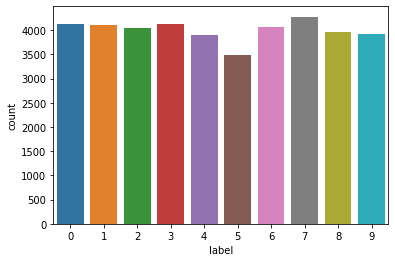

In [96]:
sns.countplot(data=test_df, x='label')

In [95]:
test_df.to_csv('./Data/submission_convmixer9.csv', index=False)